In [1]:
from pyfmi import load_fmu
import yaml
import numpy as np
import datetime
import scipy
import matplotlib.pyplot as plt
import pandas as pd
import time
import os

In [2]:

fmuName='R32HpTesTest_parallel.fmu'


In [3]:
#Load the FMU
model = load_fmu(fmuName)
fmuNameNoSuffix=fmuName.replace(".fmu","")


In [4]:
# all time is in seconds
start_time=0
final_time=43200
control_timestep = 10800
data_interval=60

In [5]:
current_time=start_time
iteration=1

while current_time+control_timestep <= final_time:

    
    
    current_control_timestep_start_time=current_time
    current_control_timestep_final_time=current_time+control_timestep

    
    # this if-else code block is used to save the previous model state for each control timestep
    if iteration==1:
        opts = model.simulate_options()
        opts["ncp"] = (current_control_timestep_final_time-current_control_timestep_start_time)/data_interval
    else:
        state = model.get_fmu_state()
        opts['initialize'] = False
        opts["ncp"] = (current_control_timestep_final_time-current_control_timestep_start_time)/data_interval
        model.set_fmu_state(state)
    
    
    # The "inputs_dict_at_*" variable and the "inputs" variable are used to define the inputs to the FMU model at each control timestep
    inputs_dict_at_start_time={
        'SysMode':1,
        'HeatPumpWaterSupplyMassFlow':0.29,
        'HeatPumpOnOff':1,
        'HeatPumpMode':1,
        'HeatPumpWaterTempSetpoint':273.15+62,
        'OutdoorAirTemperature':273.15-1,
        'PCMPumpWaterSupplyMassFlow':0,
        'ZoneHeatingLoad':500,
    }
    inputs_dict_at_intermediate_time_1={
        'SysMode':1,
        'HeatPumpWaterSupplyMassFlow':0.29,
        'HeatPumpOnOff':1,
        'HeatPumpMode':1,
        'HeatPumpWaterTempSetpoint':273.15+62,
        'OutdoorAirTemperature':273.15-1,
        'PCMPumpWaterSupplyMassFlow':0,
        'ZoneHeatingLoad':750,
    }
    inputs_dict_at_intermediate_time_2={
        'SysMode':1,
        'HeatPumpWaterSupplyMassFlow':0.29,
        'HeatPumpOnOff':1,
        'HeatPumpMode':1,
        'HeatPumpWaterTempSetpoint':273.15+62,
        'OutdoorAirTemperature':273.15-1,
        'PCMPumpWaterSupplyMassFlow':0,
        'ZoneHeatingLoad':1000,
    }
    inputs_dict_at_end_time={
        'SysMode':1,
        'HeatPumpWaterSupplyMassFlow':0.29,
        'HeatPumpOnOff':1,
        'HeatPumpMode':1,
        'HeatPumpWaterTempSetpoint':273.15+62,
        'OutdoorAirTemperature':273.15-1,
        'PCMPumpWaterSupplyMassFlow':0,
        'ZoneHeatingLoad':750,
    }
    inputs = (
        list(inputs_dict_at_start_time), 
        np.array(
            [[current_control_timestep_start_time]+list(inputs_dict_at_start_time.values()),
             [current_control_timestep_start_time+control_timestep*0.2]+list(inputs_dict_at_start_time.values()),
             [current_control_timestep_start_time+control_timestep*0.2]+list(inputs_dict_at_intermediate_time_1.values()),
             [current_control_timestep_start_time+control_timestep*0.6]+list(inputs_dict_at_intermediate_time_1.values()),
             [current_control_timestep_start_time+control_timestep*0.6]+list(inputs_dict_at_intermediate_time_2.values()),
             [current_control_timestep_final_time]+list(inputs_dict_at_intermediate_time_2.values()),
             [current_control_timestep_final_time]+list(inputs_dict_at_end_time.values()),]
        )
    )
    
    # This runs the simulation
    res = model.simulate(start_time=current_control_timestep_start_time, final_time=current_control_timestep_final_time,input=inputs, options=opts)
    
    # This converts the resulting MAT files to csv files
    !python MAT_to_CSV_conversion.py {fmuNameNoSuffix+'_result.mat'} {fmuNameNoSuffix+'_data_points.csv'}
    
    
    df_current = pd.read_csv(fmuNameNoSuffix+'_result.csv')
    df_current=df_current.drop(['Unnamed: 0'], axis=1)
    
    # The 'output_variables_dict' variable is used to store the simulation outputs at the end of each control timestep
    # If you want to apply external control to this simulation, you could find a way to use 
    # the 'output_variables_dict' variable to control the 'inputs' variable
    output_variables_dict=df_current.iloc[-1].to_dict()
    
    if iteration==1:
        df = pd.DataFrame()

    df=pd.concat([df[:-1], df_current], ignore_index=True)    
    
    iteration+=1
    current_time += control_timestep

Could not find GLIMDA.


Final Run Statistics: --- 

 Number of steps                                 : 591
 Number of function evaluations                  : 801
 Number of Jacobian evaluations                  : 21
 Number of function eval. due to Jacobian eval.  : 0
 Number of error test failures                   : 29
 Number of nonlinear iterations                  : 788
 Number of nonlinear convergence failures        : 10
 Number of state function evaluations            : 969
 Number of state events                          : 3

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : [1.0e-01 1.0e-01 3.0e-04 3.0e-04 3.0e-04 3.0e-04 3.0e-04 3.0e-04 3.0e-04
 2.7e-01 2.7e-01 1.0e-06 1.0e-06 1.0e-06 1.0e-06 1.0e-06 1.0e-01 1.0e-01
 1.0e-06 3.0e-04 3.0e-04 3.0e-04 3.0e-04 1.0e-06 1.0e-06 1.0e-06 1.0e-06
 1.0e-06 1.0e-08 1.0e-01 1.0e-06 1.0e-06 1.0e-01 1.0e-

In [6]:
try:
    os.remove(fmuNameNoSuffix+'_result.mat')
except:
    pass
try:
    os.remove(fmuNameNoSuffix+'_result.csv')
except:
    pass

try:
    os.remove(fmuNameNoSuffix+'_log.txt')
except:
    pass

In [7]:
df.to_csv(fmuNameNoSuffix+'_result.csv',index=False)

# Plotting

Text(0, 0.5, 'ZoneHeatingLoad')

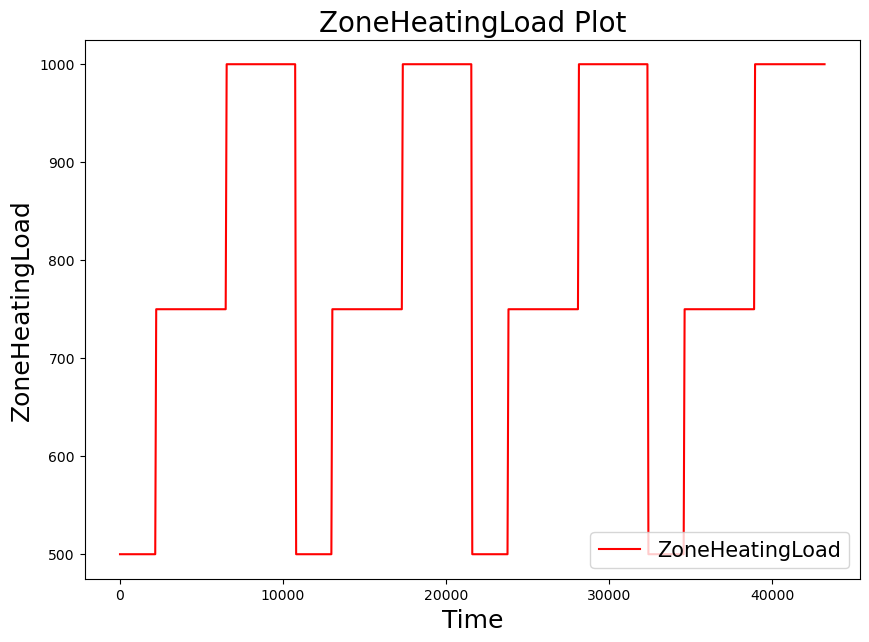

In [8]:

fig,ax=plt.subplots(nrows=1,ncols=1,figsize=(10,7))

ax.plot(df['time'],df['ZoneHeatingLoad'], label="ZoneHeatingLoad",color="red")



ax.legend(fontsize=15)
ax.set_title(f'ZoneHeatingLoad Plot',fontsize=20)
ax.set_xlabel('Time',fontsize=18)
ax.set_ylabel('ZoneHeatingLoad',fontsize=18)
